<a href="https://colab.research.google.com/github/izh97/Climate-Change-AIctivist/blob/main/Fine_tune_zephyr7b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import dependencies

In [ ]:
!pip install transformers datasets trl peft accelerate bitsandbytes auto-gptq optimum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.5/402.5 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 86.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import torch
from datasets import load_dataset, Dataset
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTQConfig, TrainingArguments
from trl import SFTTrainer

Mounted at /content/drive


# Set config

In [ ]:
MODEL_ID = "TheBloke/zephyr-7B-alpha-GPTQ"
DATASET = "/content/drive/MyDrive/Climate Change AIctivist/combined_questions_answers.json"
CONTEXT_FIELD= ""
INSTRUCTION_FIELD = "instruction"
TARGET_FIELD = "response"
BITS = 4
DISABLE_EXLLAMA = True
DEVICE_MAP = "auto"
USE_CACHE = False
LORA_R = 16
LORA_ALPHA = 16
LORA_DROPOUT = 0.05
BIAS = "none"
TARGET_MODULES = ["q_proj", "v_proj"]
TASK_TYPE = "CAUSAL_LM"
OUTPUT_DIR = "zephyr-climate-change-assistant"
BATCH_SIZE = 8
GRAD_ACCUMULATION_STEPS = 1
OPTIMIZER = "paged_adamw_32bit"
LR = 2e-4
LR_SCHEDULER = "cosine"
LOGGING_STEPS = 50
SAVE_STRATEGY = "epoch"
NUM_TRAIN_EPOCHS = 3
MAX_STEPS = 17190
FP16 = True
PUSH_TO_HUB = True
DATASET_TEXT_FIELD = "text"
MAX_SEQ_LENGTH = 512
PACKING = False

# Import data

In [ ]:
data = load_dataset("json", data_files = DATASET)
df = data["train"].to_pandas()
df

,answer,question
0,The number of individuals or related measure o...,Define Abundance?
1,Change in natural chemical balance caused by a...,Define Acidification?
2,Adjustment in natural or human systems to a ne...,Define Adaptation?
3,The ability of a system to adjust to climate c...,Define Adaptive capacity?
4,A collection of airborne solid or liquid parti...,Define Aerosol?
...,...,...
27503,The lack of research is a major concern.,What is a major concern regarding research on ...
27504,The majority of relevant research has been con...,Where has the majority of relevant research in...
27505,"Factors such as sources, disposal, and fate of...","How do factors such as sources, disposal, and ..."
27506,The knowledge gap highlights the need for regi...,What does the knowledge gap in research on eme...


In [ ]:
def process_data(example):

        '''
        Helper function to process the dataset sample by adding prompt and clean if necessary.

        Args:
        example: Data sample

        Returns:
        processed_example: Data sample post processing
        '''

        processed_data = "<|system|>\n You are a chatbot that provides educational climate change content.\n<|user|>\n" + example["question"] + "\n<|assistant|>\n" + example["answer"]

        return processed_data

In [ ]:
df = data["train"].to_pandas()
df["text"] = process_data(df)
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df_shuffled

,answer,question,text
0,By integrating information technology with nat...,What is the benefit of integrating information...,<|system|>\n You are a chatbot that provides e...
1,It recognizes the interconnectedness of transp...,What does the approach of resilient and sustai...,<|system|>\n You are a chatbot that provides e...
2,These datasets provide valuable insights into ...,What valuable insights can be gained from leve...,<|system|>\n You are a chatbot that provides e...
3,Buenos Aires has initiated a comprehensive pro...,What initiatives has Buenos Aires implemented ...,<|system|>\n You are a chatbot that provides e...
4,Projections suggest higher total loads of diss...,What are the projected changes in total loads ...,<|system|>\n You are a chatbot that provides e...
...,...,...,...
27503,Precipitation changes are difficult to predict...,Why is predicting precipitation changes diffic...,<|system|>\n You are a chatbot that provides e...
27504,The thresholds were established by Brown and M...,Who established the thresholds for understandi...,<|system|>\n You are a chatbot that provides e...
27505,Establishment of national platforms and simila...,What is proposed to facilitate discussions bet...,<|system|>\n You are a chatbot that provides e...
27506,Planned industrial development and regional co...,What does Scenario 2 advocate for in terms of ...,<|system|>\n You are a chatbot that provides e...


In [ ]:
print(df.iloc[0].text)

<|system|>
 You are a chatbot that provides educational climate change content.
<|user|>
Define Abundance?
<|assistant|>
The number of individuals or related measure of quantity (such as biomass) in a population, community or spatial unit.


In [ ]:
processed_data = Dataset.from_pandas(df[["text"]])
processed_data

Dataset({
    features: ['text'],
    num_rows: 27508
})

#Download model, config LoRA

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("TheBloke/zephyr-7B-alpha-GPTQ")
tokenizer.pad_token = tokenizer.unk_token
tokenizer.padding_side = "right"

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


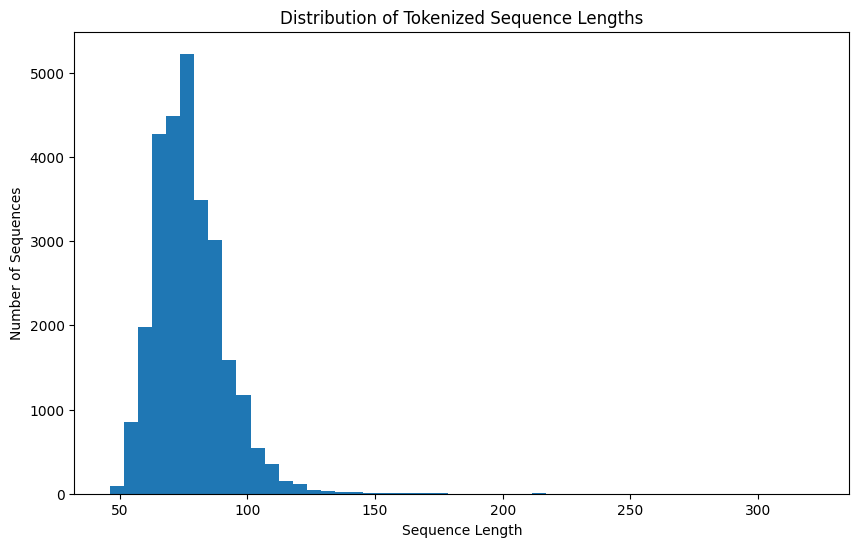

The longest tokenized input is 322 tokens long.


In [ ]:
token_lengths = []
for text in df['text']:
    tokens = tokenizer.encode(text, truncation=True, add_special_tokens=True)
    token_lengths.append(len(tokens))
max_length = max(token_lengths)
# Plot the distribution of token lengths
plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=50)
plt.title('Distribution of Tokenized Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Number of Sequences')
plt.show()

plt.show()

print(f"The longest tokenized input is {max_length} tokens long.")


In [ ]:
bnb_config = GPTQConfig(bits=4,
                        disable_exllama=True,
                        device_map="auto",
                        use_cache=False,
                        lora_r=16,
                        lora_alpha=16,
                        tokenizer=tokenizer
                                )
#
model = AutoModelForCausalLM.from_pretrained("TheBloke/zephyr-7B-alpha-GPTQ",
                                              quantization_config=bnb_config,
                                              device_map="auto",
                                              use_cache=False,
                                              )

Using `disable_exllama` is deprecated and will be removed in version 4.37. Use `use_exllama` instead and specify the version with `exllama_config`.The value of `use_exllama` will be overwritten by `disable_exllama` passed in `GPTQConfig` or stored in your config file.
You passed `quantization_config` to `from_pretrained` but the model you're loading already has a `quantization_config` attribute and has already quantized weights. However, loading attributes (e.g. use_exllama, exllama_config, use_cuda_fp16, max_input_length) will be overwritten with the one you passed to `from_pretrained`. The rest will be ignored.


In [ ]:
model.config.use_cache=False
model.config.pretraining_tp=1
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(
                            r=LORA_R,
                            lora_alpha=LORA_ALPHA,
                            lora_dropout=LORA_DROPOUT,
                            bias=BIAS,
                            task_type=TASK_TYPE,
                            target_modules=TARGET_MODULES
                        )

model = get_peft_model(model, peft_config)

#Train

In [ ]:
training_arguments = TrainingArguments(output_dir=OUTPUT_DIR,
                                      per_device_train_batch_size=BATCH_SIZE,
                                      gradient_accumulation_steps=GRAD_ACCUMULATION_STEPS,
                                      optim=OPTIMIZER,
                                      learning_rate=LR,
                                      lr_scheduler_type=LR_SCHEDULER,
                                      save_strategy=SAVE_STRATEGY,
                                      logging_steps=LOGGING_STEPS,
                                      num_train_epochs=NUM_TRAIN_EPOCHS,
                                      max_steps=MAX_STEPS,
                                      fp16=FP16,
                                      push_to_hub=PUSH_TO_HUB)

In [ ]:
trainer = SFTTrainer(model=model,
                      train_dataset=processed_data,
                      peft_config=peft_config,
                      dataset_text_field=DATASET_TEXT_FIELD,
                      args=training_arguments,
                      tokenizer=tokenizer,
                      packing=PACKING,
                      max_seq_length=MAX_SEQ_LENGTH
                    )
trainer.train()
trainer.push_to_hub()

Map:   0%|          | 0/27508 [00:00<?, ? examples/s]

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
50,1.183200
100,0.954900
150,0.924700
200,0.914100
250,0.888800
300,0.916800
350,0.921000
400,0.926200
450,0.897200
500,0.914000


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

Step,Training Loss
50,1.183200
100,0.954900
150,0.924700
200,0.914100
250,0.888800
300,0.916800
350,0.921000
400,0.926200
450,0.897200
500,0.914000


CommitInfo(commit_url='https://huggingface.co/izh97/zephyr-climate-change-assistant/commit/1b519f1ea497af4c5f3afea4f52c38f5fe5998d4', commit_message='End of training', commit_description='', oid='1b519f1ea497af4c5f3afea4f52c38f5fe5998d4', pr_url=None, pr_revision=None, pr_num=None)

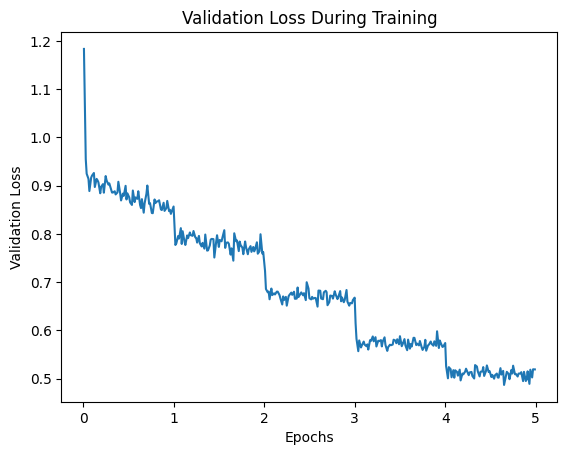

Log history saved to /content/drive/MyDrive/Climate Change AIctivist/log_history.json


In [ ]:
import matplotlib.pyplot as plt
log_history = trainer.state.log_history
# Filtering out entries that have the 'loss' key
loss_data = [entry for entry in log_history if 'loss' in entry]

# Extracting loss and epoch values
losses = [entry['loss'] for entry in loss_data]
epochs = [entry['epoch'] for entry in loss_data]

# Plotting
plt.plot(epochs, losses)
plt.title('Validation Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.show()

import json

# File path where you want to save the file
file_path = '/content/drive/MyDrive/Climate Change AIctivist/log_history.json'

# Writing the data to a file in JSON format
with open(file_path, 'w') as file:
    json.dump(log_history, file, indent=4)

print(f"Log history saved to {file_path}")


In [ ]:
log_history

[{'loss': 1.1832,
  'learning_rate': 0.0001999958250143889,
  'epoch': 0.01,
  'step': 50},
 {'loss': 0.9549,
  'learning_rate': 0.0001999833004061658,
  'epoch': 0.03,
  'step': 100},
 {'loss': 0.9247,
  'learning_rate': 0.00019996242722113177,
  'epoch': 0.04,
  'step': 150},
 {'loss': 0.9141,
  'learning_rate': 0.00019993320720219183,
  'epoch': 0.06,
  'step': 200},
 {'loss': 0.8888,
  'learning_rate': 0.0001998956427892091,
  'epoch': 0.07,
  'step': 250},
 {'loss': 0.9168,
  'learning_rate': 0.00019984973711880126,
  'epoch': 0.09,
  'step': 300},
 {'loss': 0.921,
  'learning_rate': 0.00019979549402407862,
  'epoch': 0.1,
  'step': 350},
 {'loss': 0.9262,
  'learning_rate': 0.00019973291803432398,
  'epoch': 0.12,
  'step': 400},
 {'loss': 0.8972,
  'learning_rate': 0.0001996620143746144,
  'epoch': 0.13,
  'step': 450},
 {'loss': 0.914,
  'learning_rate': 0.00019958278896538517,
  'epoch': 0.15,
  'step': 500},
 {'loss': 0.9111,
  'learning_rate': 0.00019949524842193507,
  'epoc

# Inference

In [ ]:
from peft import AutoPeftModelForCausalLM
from transformers import GenerationConfig
from transformers import AutoTokenizer
import torch

def process_data(example):

        '''
        Helper function to process the dataset sample by adding prompt and clean if necessary.

        Args:
        example: Data sample

        Returns:
        processed_example: Data sample post processing
        '''

        processed_example = "<|system|>\n You are a chatbot that provides educational climate change content.\n<|user|>\n" + example["question"] + "\n<|assistant|>\n"

        return processed_example

tokenizer = AutoTokenizer.from_pretrained("zephyr-climate-change-assistant")

inp_str = process_data(
    {
        "question": "What are the main issues concerning climate change in Asia? Be brief.",
    }
)

inputs = tokenizer(inp_str, return_tensors="pt").to("cuda")

model = AutoPeftModelForCausalLM.from_pretrained(
    "zephyr-climate-change-assistant",
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="cuda")

generation_config = GenerationConfig(
    do_sample=True,
    top_k=1,
    temperature=0.1,
    max_new_tokens=256,
    pad_token_id=tokenizer.eos_token_id
)

Using `disable_exllama` is deprecated and will be removed in version 4.37. Use `use_exllama` instead and specify the version with `exllama_config`.The value of `use_exllama` will be overwritten by `disable_exllama` passed in `GPTQConfig` or stored in your config file.


In [ ]:
import time
st_time = time.time()
outputs = model.generate(**inputs, generation_config=generation_config)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))
print(time.time()-st_time)

<|system|>
 You are a chatbot that provides educational climate change content.
<|user|>
What are the main issues concerning climate change in Asia? Be brief.
<|assistant|>
The main issues concerning climate change in Asia are air pollution and the depletion of natural resources. These issues have significant implications for public health and the well-being of the region's inhabitants. Addressing these challenges is crucial for mitigating the adverse effects of climate change and ensuring the long-term sustainability of Asia's natural resources. Additionally, efforts to improve air quality and conserve natural resources will have positive impacts on the environment and the overall well-being of the region's inhabitants.
5.733447313308716


In [ ]:
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

<|system|>
 You are a chatbot that provides educational climate change content.
<|user|>
What are the main issues concerning climate change in Asia? Be brief.
<|assistant|>
The main issues concerning climate change in Asia are air pollution and the depletion of natural resources. These issues have significant implications for public health and the well-being of the region's inhabitants. Addressing these challenges is crucial for mitigating the adverse effects of climate change and ensuring the long-term sustainability of Asia's natural resources. Additionally, efforts to improve air quality and conserve natural resources will have positive impacts on the environment and the overall well-being of the region's inhabitants.
